LIMPEZA DOS DADOS

In [1]:
import sklearn as sk
import matplotlib as mt
import seaborn as sb
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

In [2]:
df = pd.read_csv("dataset.csv")

In [3]:
# A base ta limpinha
print(df)
df.duplicated().sum()
df.isnull().sum()

         region    category           parameter  mode powertrain  year  \
0     Australia  Historical            EV sales  Cars        BEV  2011   
1     Australia  Historical      EV stock share  Cars         EV  2011   
2     Australia  Historical      EV sales share  Cars         EV  2011   
3     Australia  Historical            EV stock  Cars        BEV  2011   
4     Australia  Historical            EV stock  Cars        BEV  2012   
...         ...         ...                 ...   ...        ...   ...   
3793      World  Historical            EV stock  Cars        BEV  2023   
3794      World  Historical            EV sales  Cars        BEV  2023   
3795      World  Historical      EV sales share  Cars         EV  2023   
3796      World  Historical      EV stock share  Cars         EV  2023   
3797      World  Historical  Electricity demand  Cars         EV  2023   

          unit         value  
0     Vehicles  4.900000e+01  
1      percent  3.900000e-04  
2      percent  6.

region        0
category      0
parameter     0
mode          0
powertrain    0
year          0
unit          0
value         0
dtype: int64

In [4]:
# Renomear as colunas em pt-br pra facilitar a vida
df = df.rename(columns={
    'region': 'regiao',
    'category': 'categoria',
    'parameter': 'parametro',
    'mode': 'tipo_veiculo',
    'powertrain': 'motorizacao',
    'year': 'ano',
    'unit': 'unidade',
    'value': 'valor'
})

In [11]:

regiao_continente = {
    'World': 'World',
    'Europe': 'Europe',
    'EU27': 'Europe',
    'France': 'Europe',
    'Germany': 'Europe',
    'Italy': 'Europe',
    'United Kingdom': 'Europe',
    'Spain': 'Europe',
    'Portugal': 'Europe',
    'Norway': 'Europe',
    'Sweden': 'Europe',
    'Finland': 'Europe',
    'Denmark': 'Europe',
    'Iceland': 'Europe',
    'Poland': 'Europe',
    'Netherlands': 'Europe',
    'Belgium': 'Europe',
    'Austria': 'Europe',
    'Luxembourg': 'Europe',
    'Switzerland': 'Europe',
    'Ireland': 'Europe',
    'Czech Republic': 'Europe',
    'Slovakia': 'Europe',
    'Hungary': 'Europe',
    'Slovenia': 'Europe',
    'Croatia': 'Europe',
    'Bulgaria': 'Europe',
    'Greece': 'Europe',
    'Rest of the world': 'Outros',
    'Estonia': 'Europe',
    'Latvia': 'Europe',
    'Lithuania': 'Europe',
    'Romania': 'Europe',
    'Cyprus': 'Europe',
    'Seychelles': 'Africa',
    'South Africa': 'Africa',
    'Canada': 'America',
    'USA': 'America',
    'Mexico': 'America',
    'Brazil': 'America',
    'Chile': 'America',
    'Colombia': 'America',
    'Costa Rica': 'America',
    'China': 'Asia',
    'India': 'Asia',
    'Japan': 'Asia',
    'Korea': 'Asia',
    'Israel': 'Asia',
    'Turkey': 'Asia',
    'Turkiye': 'Asia', 
    'United Arab Emirates': 'Asia',
    'Australia': 'Oceania',
    'New Zealand': 'Oceania',
    'Rest of the world': 'Outros'
    
}

df['continente'] = df['regiao'].map(regiao_continente).fillna('Outros')

print(df['continente'].value_counts())
df.to_csv('dataset_com_continente.csv', index=False)


continente
Europe     2152
Asia        592
America     515
Oceania     174
World       154
Outros      124
Africa       87
Name: count, dtype: int64


In [13]:
df_limpo = pd.read_csv("dataset_com_continente.csv")

FILTROS 

In [14]:
# Filtrar somente vendas anuais (parametro = 'EV sales' e unidade = 'Vehicles')
df_vendas = df_limpo[(df_limpo['parametro'] == 'EV sales') & (df_limpo['unidade'] == 'Vehicles')]

# Visualizar as primeiras linhas para confirmar
print(df_vendas.head())
print(df_vendas.columns)


       regiao   categoria parametro tipo_veiculo motorizacao   ano   unidade  \
0   Australia  Historical  EV sales         Cars         BEV  2011  Vehicles   
6   Australia  Historical  EV sales         Cars        PHEV  2012  Vehicles   
9   Australia  Historical  EV sales         Cars         BEV  2012  Vehicles   
10  Australia  Historical  EV sales         Cars         BEV  2013  Vehicles   
13  Australia  Historical  EV sales         Cars        PHEV  2013  Vehicles   

    valor continente  
0    49.0    Oceania  
6    80.0    Oceania  
9   170.0    Oceania  
10  190.0    Oceania  
13  100.0    Oceania  
Index(['regiao', 'categoria', 'parametro', 'tipo_veiculo', 'motorizacao',
       'ano', 'unidade', 'valor', 'continente'],
      dtype='object')


In [15]:
# Transformar a coluna valor (quantidade de veículos vendidos) em uma variável categórica, dividindo as vendas em faixas: “baixo”, “médio” e “alto” para classificação.
# Usamos a função pd.qcut() para criar as três faixas baseadas nos tercis (ou seja, dividindo os dados em três partes iguais).
# Criando a variável-alvo: faixa de vendas
df_vendas['faixa_vendas'] = pd.qcut(df_vendas['valor'], q=3, labels=['baixo', 'medio', 'alto'])

# Conferindo o resultado
print(df_vendas[['regiao', 'ano', 'valor', 'faixa_vendas']].sample(10))
print(df_vendas['faixa_vendas'].value_counts())


              regiao   ano    valor faixa_vendas
2684        Portugal  2013    150.0        baixo
2460     New Zealand  2020   3900.0        medio
2919        Slovakia  2018    290.0        medio
1702           India  2016    730.0        medio
532            Chile  2021      1.0        baixo
375         Bulgaria  2023    360.0        medio
906          Estonia  2020    340.0        medio
3458  United Kingdom  2018  46000.0         alto
2283          Mexico  2022   4400.0        medio
716       Costa Rica  2017     25.0        baixo
faixa_vendas
baixo    449
alto     448
medio    445
Name: count, dtype: int64


C:\Users\Jessica\AppData\Local\Temp\ipykernel_25308\2600422441.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vendas['faixa_vendas'] = pd.qcut(df_vendas['valor'], q=3, labels=['baixo', 'medio', 'alto'])


PRÉ PROCESSAMENTO

In [26]:
#  Separação das variáveis
# Features e variável-alvo
features = ['continente', 'ano', 'motorizacao'] 
X = df_vendas[features]
y = df_vendas['faixa_vendas']

In [27]:
# Separar conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [28]:
# Transformar variáveis categóricas
# Como temos categorias (ex: países, tipos de motorização), precisamos codificá-las.

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Ajustar e transformar os dados
X_train_enc = ohe.fit_transform(X_train)
X_test_enc = ohe.transform(X_test)


In [29]:
# Conferência
print("Shape do X_train_enc:", X_train_enc.shape)
print("Shape do X_test_enc:", X_test_enc.shape)
print("Classes alvo:", y.unique())


Shape do X_train_enc: (939, 24)
Shape do X_test_enc: (403, 24)
Classes alvo: ['baixo', 'medio', 'alto']
Categories (3, object): ['baixo' < 'medio' < 'alto']


BALANCEAMENTO

In [33]:
from imblearn.over_sampling import SMOTE
from collections import Counter

df_balanceamento = pd.read_csv("dataset_com_continente.csv")


# Quantidade de valores únicos em cada coluna
print("Valores únicos por coluna:")
for col in df_balanceamento.columns:
    print(f"{col}: {df_balanceamento[col].nunique()} únicos")
    print(df_balanceamento[col].value_counts().head(), "\n")

# Ajuste aqui para o nome correto da coluna, por exemplo:
coluna_alvo = 'continente'  # ou 'continente', conforme está no seu CSV

# Verifica se é possível balancear essa coluna
if df_balanceamento[coluna_alvo].nunique() < 2:
    print(f"Não é possível balancear '{coluna_alvo}' pois só tem uma classe.")
else:
    # distribuição original
    print(f"Distribuição original de '{coluna_alvo}':")
    print(df_balanceamento[coluna_alvo].value_counts())

    X = df_balanceamento.drop(columns=[coluna_alvo])
    y = df_balanceamento[coluna_alvo]

    # transformar variáveis categóricas em dummies (necessário para SMOTE)
    X_dummies = pd.get_dummies(X, drop_first=True)

    # aplicar o SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_dummies, y)

    # nova distribuição
    print(f"Distribuição balanceada de '{coluna_alvo}':")
    print(Counter(y_res))


Valores únicos por coluna:
regiao: 52 únicos
regiao
World                154
Europe               154
USA                  144
China                132
Rest of the world    124
Name: count, dtype: int64 

categoria: 1 únicos
categoria
Historical    3798
Name: count, dtype: int64 

parametro: 7 únicos
parametro
EV sales                1342
EV stock                1145
EV sales share           603
EV stock share           465
Oil displacement Mbd      84
Name: count, dtype: int64 

tipo_veiculo: 1 únicos
tipo_veiculo
Cars    3798
Name: count, dtype: int64 

motorizacao: 4 únicos
motorizacao
EV      1311
BEV     1078
PHEV     922
FCEV     487
Name: count, dtype: int64 

ano: 14 únicos
ano
2021    338
2022    336
2023    332
2020    321
2019    319
Name: count, dtype: int64 

unidade: 5 únicos
unidade
Vehicles                         2487
percent                          1068
Milion barrels per day             84
Oil displacement, million lge      84
GWh                                75
N

In [34]:
df_balanceado = pd.concat([pd.DataFrame(X_res, columns=X_dummies.columns), pd.Series(y_res, name=coluna_alvo)], axis=1)
df_balanceado.to_csv('dataset_balanceado.csv', index=False)
print("Arquivo balanceado salvo como dataset_balanceado.csv")

Arquivo balanceado salvo como dataset_balanceado.csv


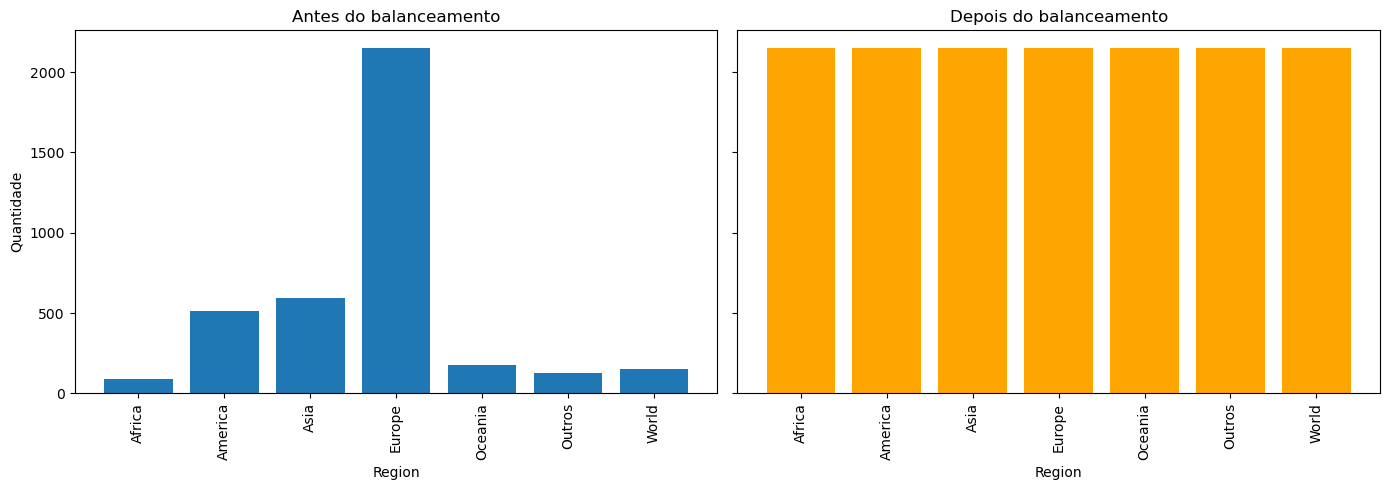

In [36]:
import matplotlib.pyplot as plt

# Antes do balanceamento
df = pd.read_csv('dataset_com_continente.csv')
counts_before = df['continente'].value_counts().sort_index()

# Depois do balanceamento
df_bal = pd.read_csv('dataset_balanceado.csv')
counts_after = df_bal['continente'].value_counts().sort_index()

# Plotando
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Antes
axes[0].bar(counts_before.index, counts_before.values)
axes[0].set_title('Antes do balanceamento')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Quantidade')
axes[0].tick_params(axis='x', rotation=90)

# Depois
axes[1].bar(counts_after.index, counts_after.values, color='orange')
axes[1].set_title('Depois do balanceamento')
axes[1].set_xlabel('Region')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


ARVORE DE DECISÃO

In [ ]:
#  Treinando o Classificador (Árvore de Decisão)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Treinamento do modelo
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train_enc, y_train)

# Previsões
y_pred = dt.predict(X_test_enc)


In [ ]:
# Avaliando o Modelo
# Relatório de classificação
print(classification_report(y_test, y_pred))

# Matriz de confusão
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))


In [ ]:
# Visualização da Árvore de Decisão

from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(22,10))
tree.plot_tree(
    dt,
    feature_names=ohe.get_feature_names_out(),
    class_names=dt.classes_,
    filled=True,
    fontsize=9,
    rounded=True
)
plt.show()


RANDOM FOREST

In [ ]:
# Treinando o Random Forest
from sklearn.ensemble import RandomForestClassifier

# Treinamento do modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)
rf.fit(X_train_enc, y_train)

# Previsões
y_pred_rf = rf.predict(X_test_enc)


In [ ]:
# Avaliando o Modelo Random Forest

from sklearn.metrics import classification_report, confusion_matrix

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_rf))


In [ ]:
# Importância das Variáveis

import numpy as np

importances = rf.feature_importances_
feature_names = ohe.get_feature_names_out()
indices = np.argsort(importances)[::-1]

print("Importância das variáveis (top 10):")
for i in range(min(10, len(feature_names))):
    print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")


COMPARATIVO 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Função para gerar um dicionário de métricas
def get_metrics(y_true, y_pred, modelo):
    return {
        'Modelo': modelo,
        'Acurácia': accuracy_score(y_true, y_pred),
        'Precisão (macro)': precision_score(y_true, y_pred, average='macro'),
        'Recall (macro)': recall_score(y_true, y_pred, average='macro'),
        'F1-score (macro)': f1_score(y_true, y_pred, average='macro')
    }

# Métricas da Árvore de Decisão
metrics_dt = get_metrics(y_test, y_pred, 'Árvore de Decisão')

# Métricas do Random Forest
metrics_rf = get_metrics(y_test, y_pred_rf, 'Random Forest')

# Organizar em DataFrame para visualização comparativa
import pandas as pd
df_comparacao = pd.DataFrame([metrics_dt, metrics_rf])

print(df_comparacao)
